# Getting Started

The main purpose of this tutorial is to ease the implementation of our library *scikit-activeml* to the new users. The *scikit-activeml* is a library that executes the most important query strategies. It is built upon the well-known machine learning frame-work *scikit-learn*, which makes it user-friendly. For better understanding, we show an exemplary cycle here. Lets start by importing the relevant packages from both *scikit-learn* and *scikit-activeml*. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import is_unlabeled, MISSING_LABEL, call_func, is_labeled
from skactiveml.classifier import PWC, SklearnClassifier, MultiAnnotClassifier 

For plotting purposes later we need a function which is written below. 

In [11]:
def plot_figure(X, y, y_oracle, clf, selector, res=21):
    # create mesh for plotting
    x_1_vec = np.linspace(min(X[:, 0]), max(X[:, 0]), res)
    x_2_vec = np.linspace(min(X[:, 1]), max(X[:, 1]), res)
    X_1_mesh, X_2_mesh = np.meshgrid(x_1_vec, x_2_vec)
    X_mesh = np.array([X_1_mesh.reshape(-1), X_2_mesh.reshape(-1)]).T

    # compute gains
    clf.fit(X, y)
    posteriors = clf.predict_proba(X_mesh)[:,0].reshape(X_1_mesh.shape)

    # compute gains
    _, scores = call_func(selector.query, X_cand=X_mesh, X=X, y=y, X_eval=X,
                          return_utilities=True)
    scores = scores.reshape(X_1_mesh.shape)

    # get indizes for plotting
    labeled_indices = np.where(is_labeled(y))[0]
    unlabeled_indices = np.where(is_unlabeled(y))[0]

    # setup figure
    fig = plt.figure(figsize=(10, 8))
    plt.xlim(min(X[:, 0]), max(X[:, 0]))
    plt.ylim(min(X[:, 1]), max(X[:, 1]))
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    cmap = plt.get_cmap('coolwarm')

    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=[[.2, .2, .2]], s=90, marker='o', zorder=3.8)
    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=[[.8, .8, .8]], s=60, marker='o', zorder=4)
    for cl, marker in zip([0,1],['D','s']):
        cl_labeled_idx = labeled_indices[y[labeled_indices] == cl]
        cl_unlabeled_idx = unlabeled_indices[y_oracle[unlabeled_indices]==cl]
        plt.scatter(X[cl_labeled_idx, 0], X[cl_labeled_idx, 1], c=np.ones(len(cl_labeled_idx))*cl, marker=marker, vmin=-0.2, vmax=1.2, cmap='coolwarm', s=20, zorder=5)
        plt.scatter(X[cl_unlabeled_idx, 0], X[cl_unlabeled_idx, 1], c=np.ones(len(cl_unlabeled_idx)) * cl, marker=marker, vmin=-0.2, vmax=1.2, cmap='coolwarm', s=20, zorder=3)
        plt.scatter(X[cl_unlabeled_idx, 0], X[cl_unlabeled_idx, 1], c='k', marker=marker, vmin=-0.1, vmax=1.1, cmap='coolwarm', s=30, zorder=2.8)

    CS = plt.contourf(X_1_mesh, X_2_mesh, scores, cmap='Greens', alpha=.75)
    CS = plt.contour(X_1_mesh, X_2_mesh, posteriors, [.5], colors='k', linewidths=[2], zorder=1)
    CS = plt.contour(X_1_mesh, X_2_mesh, posteriors, [.25,.75], cmap='coolwarm_r', linewidths=[2,2],
                     zorder=1, linestyles='--', alpha=.9, vmin=.2, vmax=.8)

    fig.tight_layout()
    plt.show()

    return fig


The classification module of *scikit-learn* framewrok does not support missing labels, so we need an extension to this issue, which is solved by **SklearnClassifier.** Next, we generate a data-set of 100 data points with two clusters from *make_classification* method of *sklearn*. We acquire its true labels as well, but in practice, it is not the case and we do not know them unless we ask the oracle.  

Text(0.5, 1.0, 'Data-set')

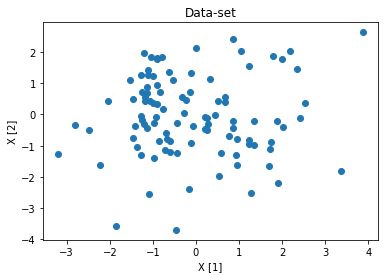

In [12]:
X, y_true = make_classification(n_features=2,n_redundant=0,random_state=0)
plt.scatter(X[:,0],X[:,1])
plt.xlabel('X [1]')
plt.ylabel('X [2]')
plt.title('Data-set')


he class for each data point is already stored in *y_true*, which acts as an oracle. Our goal is to classify the data points into two classes. To do so, we introduce a vector $y$ to store the labels that would be acquired from the oracle (*y_true*). As shown below, the vector $y$ is unlabeled at the beginning. 

In [13]:
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
print(y)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


There are many easy-to-use classification algorithms in *scikit-learn*. For example, here we use the logistic regression classifier. As *scikit-learn* classifiers are not able to cope with missing labels, we need to wrap these with the *SklearnClassifier*

In [ ]:
clf = SklearnClassifier(LogisticRegression(),  classes=np.unique(y_true))

Query strategy is the central part of our library. As a query strategy, we use the uncertainty sampling with entropy method to specify the most uncertain data points. There are other strategies as well to be used.  

In [ ]:
qs = UncertaintySampling(clf, method='entropy')

As an example, we choose to acquire $20$ labels, which means to loop around the active learning cycle $20$ times (labels to be acquired = n_cycle * batch_size). 
Inside the loop, we first get the unlabeled indices of vector $y$. All the indices for $100$ data points are unlabeled, because we are at the first iteration. 


In [ ]:
unlbld_idx = np.where(is_unlabeled(y))[0]
print(unlbld_idx)

We use those unlabeled indices to create a list of labeling set, which contain unlabeled data set, and ask the query strategy to give us the indices of the most informative data points in $X\_cand$. For example, it gives the data point with an index $68$ as the most informative data point to be labeled. The output is just a single index, because the *batch_size* is $1$.

In [14]:
X_cand = X[unlbld_idx]
query_idx = unlbld_idx[qs.query(X_cand=X_cand, X=X, y=y,
                       batch_size=1)]
print(query_idx)

[72]


Finally, we ask the oracle for the true label of the selected data point and store it in vector $y$ to train our classifier. We continue until we reach the $20$ labeled data points. 

In [15]:
y[query_idx] = y_true[query_idx]
clf.fit(X, y)

SklearnClassifier(classes=array([0, 1]), estimator=LogisticRegression())

Below, we see the implementation of an active learning cycle. The first figure represents the data points in different colors for each class. The second figure shows the decision boundary after acquiring the label of two data points. The third figure is after having 11 labeled data points from the oracle, which shows significant improvement compare to the second figure. The last figure shows the decision boundary after acquiring labels for $20$ data points. Finally, we show the data points that were selected for labeling (vector *y*). 

<ipython-input-11-0549101779bd>:39: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(X_1_mesh, X_2_mesh, posteriors, [.5], colors='k', linewidths=[2], zorder=1)
<ipython-input-11-0549101779bd>:40: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(X_1_mesh, X_2_mesh, posteriors, [.25,.75], cmap='coolwarm_r', linewidths=[2,2],


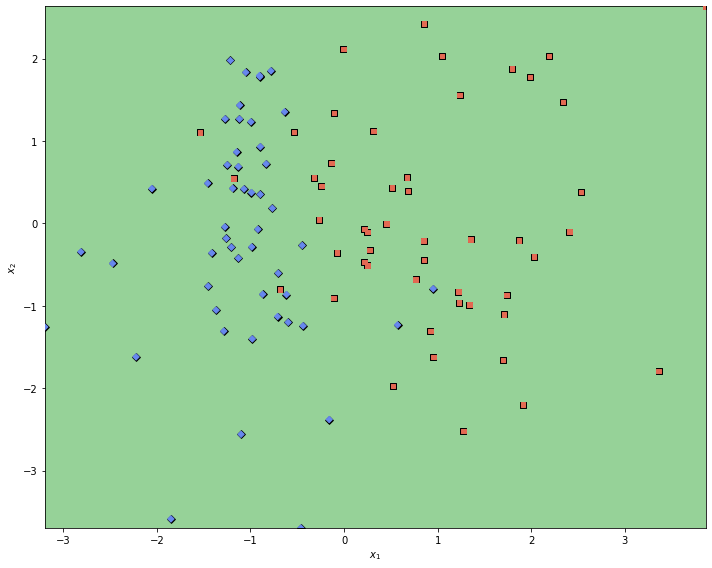

<ipython-input-11-0549101779bd>:39: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(X_1_mesh, X_2_mesh, posteriors, [.5], colors='k', linewidths=[2], zorder=1)
<ipython-input-11-0549101779bd>:40: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(X_1_mesh, X_2_mesh, posteriors, [.25,.75], cmap='coolwarm_r', linewidths=[2,2],


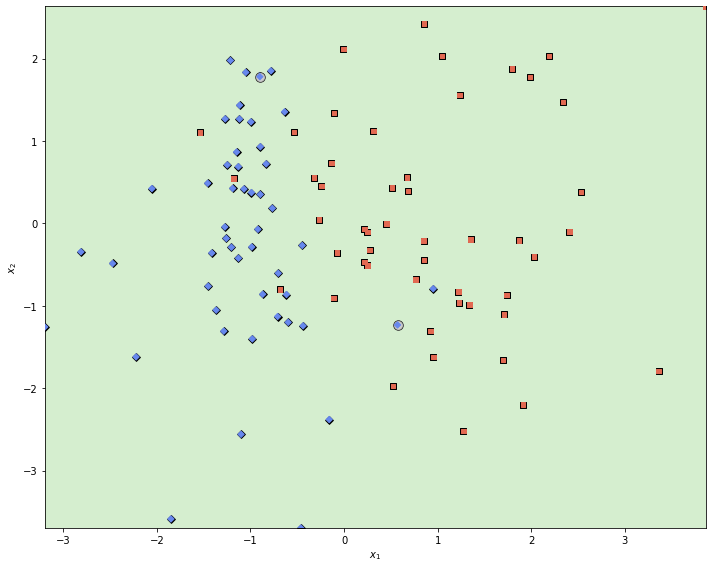

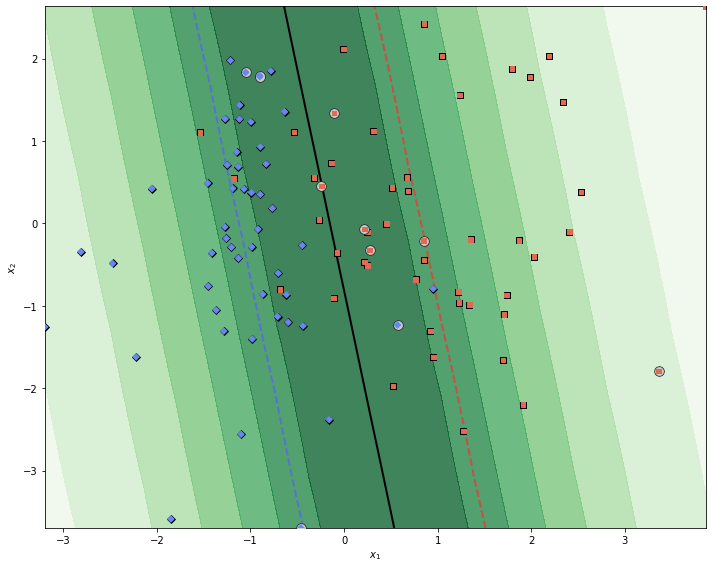

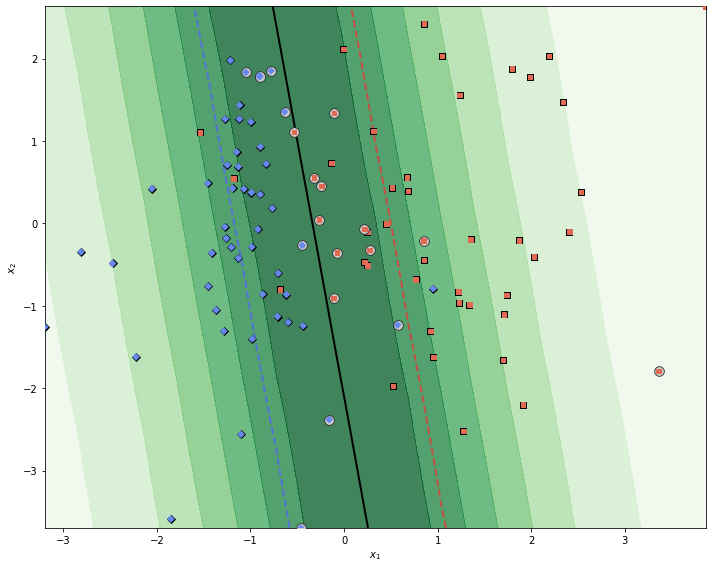

[nan nan nan nan nan nan nan nan nan  1. nan  1. nan nan nan nan nan nan
 nan nan  1. nan nan nan nan nan nan  1. nan  1. nan nan nan nan nan nan
 nan nan nan nan nan nan nan  1. nan  1. nan  0. nan nan nan  1.  1. nan
 nan nan nan nan  0.  0.  1.  0. nan nan nan  0. nan nan nan nan nan nan
 nan nan nan  0. nan nan  0. nan nan nan nan nan nan nan nan  0.  1. nan
 nan nan nan nan nan nan nan nan  0. nan]


In [16]:
X, y_true = make_classification(n_features=2,n_redundant=0,random_state=0)
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf = SklearnClassifier(LogisticRegression(),
                        classes=np.unique(y_true))
qs = UncertaintySampling(clf, method='entropy')

plot_figure(X, y, y_true, clf, qs)


n_cycles = 20
for c in range(n_cycles):
     unlbld_idx = np.where(is_unlabeled(y))[0]
     X_cand = X[unlbld_idx]
     query_idx = unlbld_idx[qs.query(X_cand=X_cand, X=X, y=y, batch_size=1)]
     y[query_idx] = y_true[query_idx]
     clf.fit(X, y)
     if c == 1 or c == 10 or c == 19:
         plot_figure(X, y, y_true, clf, qs)
print(y)
    